# Time series analysis of Ice Cream production

In [15]:
#import libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import io
import requests
register_matplotlib_converters()

In [128]:
url="https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/ice_cream.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))

## change formate
- Change columns to improve readability
- Set date column to datetime type and set as index
- Change start date to the first of january 2010

In [18]:
# rename columns
df.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)

In [21]:
# Set date column to datetime type 
df['date'] = pd.to_datetime(df.date)
# set date column as index
df.set_index('date', inplace=True)

In [23]:
# Change start date to the first of january 2010
df = df[ pd.to_datetime('2010-01-01'):]

## Plot Ice Cream production


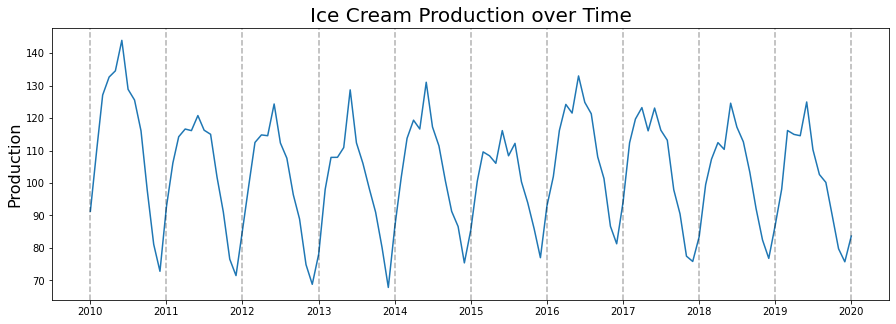

In [29]:
plt.figure(figsize=(15,5))
plt.plot(df.production)
plt.title('Ice Cream Production over Time',fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2010, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.3)

# Creating Model

## Autocorrelation function 

### Plot

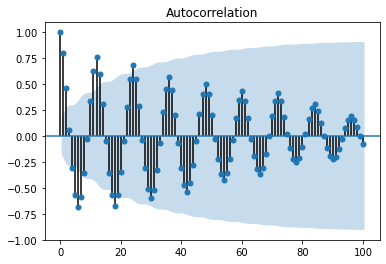

In [35]:
acf_plot = plot_acf(df.production, lags=100)

### Results
Plot shows a decaying ACF, showing that ice cream production is likely a Auto Regressive process

## Partial Autocorrelation Fucntion

### Plot

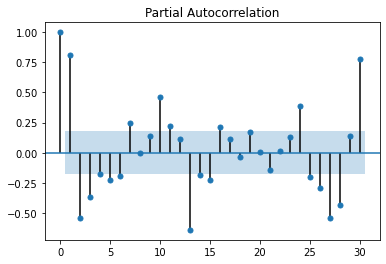

In [38]:
pacf_plot = plot_pacf(df.production, lags=30)

### Results
To start we should model Auto Regresive models with 1, 2, 3, 4, 10, 13, 27, 30

## AR model

In [40]:
from datetime import datetime
import numpy as np
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta

### Split data

In [52]:
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

train_data = df[:train_end]
test_data = df[train_end+timedelta(days=1):test_end]

### Fit AR model

In [53]:
ARmodel = ARMA(train_data, order=(3,0))

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [54]:
model_fit = ARmodel.fit()

In [55]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                   84
Model:                     ARMA(3, 0)   Log Likelihood                -294.008
Method:                       css-mle   S.D. of innovations              7.903
Date:                Tue, 26 Jan 2021   AIC                            598.015
Time:                        16:49:56   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5080      2.176     47.575      0.000      99.244     107.772
ar.L1.production     1.0488      0.099     10.573      0.000       0.854       1.243
ar.L2.production    -0.0532 

In [56]:
# Get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [80]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data.T-predictions

In [83]:
residuals=residuals.T

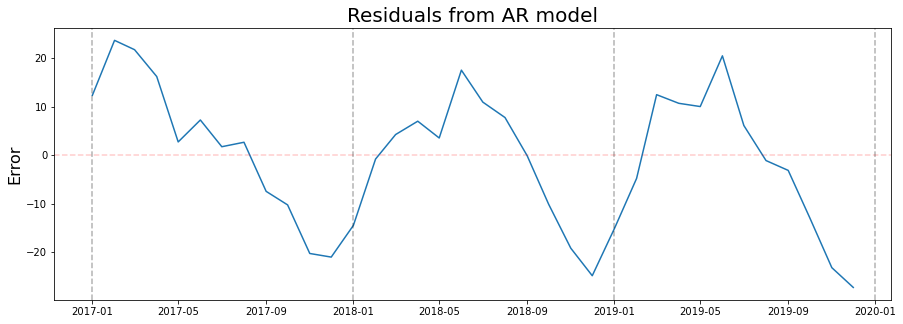

In [84]:
plt.figure(figsize=(15,5))
plt.plot(residuals)

plt.title('Residuals from AR model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
for year in range(2017, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.3)

### Discussion
There is a pattern in the residuals, therefore the model has not fully captured patterns in the data

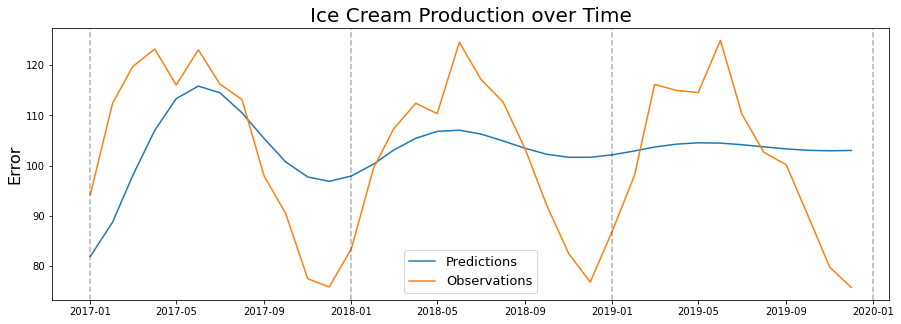

In [98]:
plt.figure(figsize=(15,5))
plt.plot(predictions, label='Predictions')
plt.plot(test_data, label='Observations')
plt.legend(fontsize=13)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Error', fontsize=16)
for year in range(2017, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.3)

difficult to predect far into the future, therefore better to performing rolling one year predictions and average the residuals

### Rolling Evalutation

In [102]:
#creating the model
pedictions_rolling = pd.Series()
for end_date in test_data.index:
    train_data = df[:end_date - timedelta(days=1)]
    model_fit = ARMA(train_data, order=(3,0)).fit()
    pred = model_fit.predict(end_date)
    pedictions_rolling.loc[end_date] = pred.loc[end_date]

<ipython-input-102-f2840ee09052>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pedictions_rolling = pd.Series()


In [104]:
residuals_rolling = test_data.T - pedictions_rolling

In [106]:
residuals_rolling = residuals_rolling.T

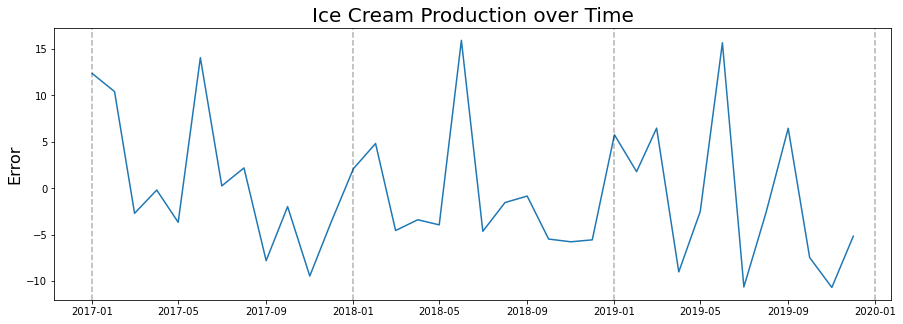

In [111]:
plt.figure(figsize=(15,5))
plt.plot(residuals_rolling)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Error', fontsize=16)
for year in range(2017, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.3)

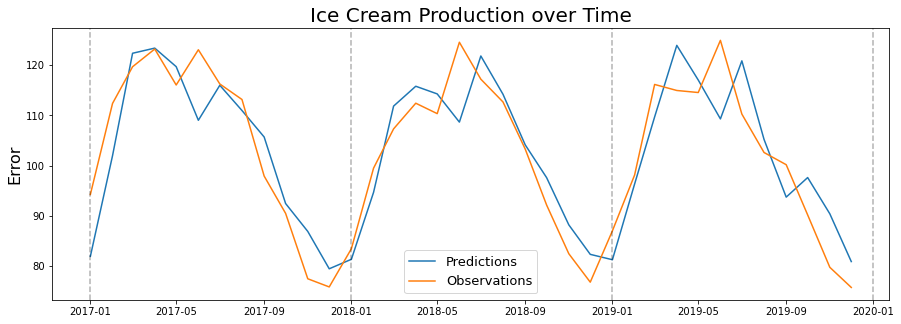

In [109]:
plt.figure(figsize=(15,5))
plt.plot(pedictions_rolling, label='Predictions')
plt.plot(test_data, label='Observations')
plt.legend(fontsize=13)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Error', fontsize=16)
for year in range(2017, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.3)

### Results
Much better fit for the predicted three years when compared to the original model.